<a href="https://colab.research.google.com/github/mzohaibnasir/NeuralNotes/blob/main/06_convolutions_deepDiveIntoBasics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#|default_exp conv


In [2]:
! git clone https://github.com/fastai/course22p2.git
!ls -a

fatal: destination path 'course22p2' already exists and is not an empty directory.
.  ..  .config	course22p2  sample_data


In [3]:
!ls /content/course22p2
!pip install -e /content/course22p2/.   # -e : editable   ; install current directory as python module


LICENSE      miniai	      nbs	 settings.ini  summaries
MANIFEST.in  miniai.egg-info  README.md  setup.py      xl
Obtaining file:///content/course22p2
  Preparing metadata (setup.py) ... done
  Attempting uninstall: miniai
    Found existing installation: miniai 0.0.1
    Uninstalling miniai-0.0.1:
      Successfully uninstalled miniai-0.0.1
  Running setup.py develop for miniai


# Convolutions

In [4]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

In [5]:
#|export

import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

mpl.rcParams['image.cmap'] = 'gray'

from miniai.training import *
from miniai.datasets import *



In [6]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/d15df08a69ed33ae16a2fff874f83b57a956172c/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True )
path_gz=path_data/'mnist.pkl.gz'
path_gz

Path('data/mnist.pkl.gz')

In [7]:
from urllib.request import urlretrieve

if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [8]:
!ls -l data


total 16656
-rw-r--r-- 1 root root 17051982 Jan 27 19:46 mnist.pkl.gz


In [9]:

with gzip.open(path_gz, 'rb') as f:   #read as binary as opposed to text
   ((x_train,y_train), (x_valid,y_valid), _) = pickle.load(f, encoding='latin-1') #destructuring
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In the context of an image, a feature is a visually distinctive attribute. For example, the number 7 is characterized by a horizontal edge near the top of the digit, and a top-right to bottom-left diagonal edge underneath that.

It turns out that finding the edges in an image is a very common task in computer vision, and is surprisingly straightforward. To do it, we use a convolution. A convolution requires nothing more than multiplication, and addition.

## Understanding the Convolution Equations
To explain the math behind convolutions, fast.ai student Matt Kleinsmith came up with the very clever idea of showing
https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c

In [10]:
# bias would be added per convolution(per kernel multiplication with pixels)

In [11]:
x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_valid.view(-1, 28, 28)

x_imgs.shape, xv_imgs.shape

(torch.Size([50000, 28, 28]), torch.Size([10000, 28, 28]))

In [12]:
mpl.rcParams['figure.dpi'] = 30

<Axes: >

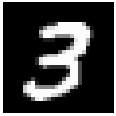

In [15]:
im3 = x_imgs[7]
show_image(im3)

<Axes: >

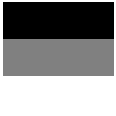

In [16]:
# lets create a kernel

top_edge = tensor([
    [-1,-1,-1],
    [0,0,0],
    [1,1,1]
]).float()

show_image(top_edge)

The filter will take any window of size 3*3 in our image, and if we name the pixel values like
*   a1 | a2 | a3
*   a4 | a5 | a6
*   a7 | a8 | a9


then output will be

* -a1 -a2 -a3 +0.a4 +0.a5 + 0.a6 + a7 + a8 + a9

In [18]:
im3.shape

torch.Size([28, 28])

In [22]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [23]:
(im3[3:6,14:17] * top_edge).sum()

tensor(2.9727)

In [24]:
(im3[7:10,14:17] * top_edge).sum()

tensor(-2.9570)

In [25]:
def apply_kernel(row, col, kernel):
  return (im3[row-1:row+2,col-1:col+2] * kernel).sum()


In [26]:
apply_kernel(4,15,top_edge)


tensor(2.9727)

In [27]:
[[(i,j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

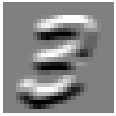

In [32]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
# print(top_edge3)
show_image(top_edge3);

In [36]:
left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()

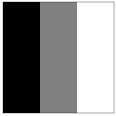

In [37]:
show_image(left_edge, noframe=False);


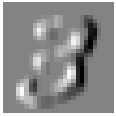

In [38]:
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

# Convolutions in PyTorch

In [40]:
import torch.nn.functional as F
import torch

In [41]:
inp = im3[None,None,:,:].float()
inp_unf = F.unfold(inp, (3,3))[0]
inp.shape, inp_unf.shape

(torch.Size([1, 1, 28, 28]), torch.Size([9, 676]))

In [50]:
inp.view(28,-1).shape

torch.Size([28, 28])

In [52]:
F.unfold(inp, (3,3)).shape

torch.Size([1, 9, 676])